In [35]:
import json
import os
from collections import Counter

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


### 1. SETUP PATH

In [36]:
# os.getcwd() di VSCode notebook = folder notebooks/, jadi naik 1 level
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PROC_DIR = os.path.join(BASE_DIR, "data", "processed")

INPUT_PATH = os.path.join(DATA_PROC_DIR, "train_data_bieos.json")
OUTPUT_PATH = os.path.join(DATA_PROC_DIR, "dataset_indobert_bieos.pt")

MODEL_NAME = "indobenchmark/indobert-large-p2"
MAX_LENGTH = 128

print(f"BASE_DIR: {BASE_DIR}")
print(f"Input exists: {os.path.exists(INPUT_PATH)}")
print(f"Model: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")

BASE_DIR: d:\Kuliah\TA\Notebook
Input exists: True
Model: indobenchmark/indobert-large-p2
Max length: 128


### 2. LOAD DATA BIEOS

In [37]:
with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

print(f"Total data: {len(raw_data)}")
print(f"\nContoh:")
for d in raw_data[:2]:
    print(f"  tokens: {d['tokens']}")
    print(f"  labels: {d['labels']}\n")

Total data: 2451

Contoh:
  tokens: ['banyak', 'hewan', 'blekok', 'nya']
  labels: ['O', 'B-NEU', 'E-NEU', 'O']

  tokens: ['ekowisata', 'kampung', 'blekok', 'di', 'dusun', 'pesisir', ',', 'desa', 'klatakan', ',', 'kecamatan', 'kendit', ',', 'situbondo', ',', 'jawa', 'timur', ',', 'sudah', 'menjadi', 'rujukan', 'wisatawan', '.', 'setiap', 'hari', ',', 'wisatawan', 'dari', 'berbagai', 'daerah', 'selalu', 'ramai', 'mengunjungi', 'destinasi', 'wisata', 'itu', '.', 'lokasi', 'wisata', 'ini', 'terletak', 'di', 'jalur', 'pantai', 'utara', '(', 'pantura', ')', ',', 'dekat', 'dari', 'pusat', 'kota', 'situbondo', ',', 'sekitar', 'sembilan', 'kilometer', '.', 'waktu', 'jarak', 'tempuh', 'hanya', 'sekitar', '20', 'menit', 'dari', 'situbondo', '.', 'meski', 'masih', 'baru', ',', 'destinasi', 'wisata', 'ini', 'sudah', 'memiliki', 'daya', 'tarik', 'yang', 'kuat', '.', 'sebab', ',', 'memiliki', 'ribuan', 'burung', 'air', 'di', 'dalamnya', '.', 'mulai', 'dari', 'jenis', 'blekok', 'sawah', 'atau', 'ard

### 3. LABEL MAPPING

In [38]:
# Kumpulkan semua unique label dari data
all_labels = sorted(set(l for d in raw_data for l in d['labels']))

# Buat mapping: O di index 0, lalu sisanya alphabetically
label_list = ['O'] + [l for l in all_labels if l != 'O']
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

IGNORE_INDEX = -100  # PyTorch CrossEntropyLoss akan ignore index ini

print(f"Jumlah label: {len(label_list)}")
print(f"\nLabel mapping:")
for l, i in label2id.items():
    print(f"  {i:3d} -> {l}")

Jumlah label: 13

Label mapping:
    0 -> O
    1 -> B-NEG
    2 -> B-NEU
    3 -> B-POS
    4 -> E-NEG
    5 -> E-NEU
    6 -> E-POS
    7 -> I-NEG
    8 -> I-NEU
    9 -> I-POS
   10 -> S-NEG
   11 -> S-NEU
   12 -> S-POS


### 4. LOAD TOKENIZER IndoBERT

In [39]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Test tokenisasi
test_tokens = ["wisata", "kampung", "blekok"]
test_enc = tokenizer(test_tokens, is_split_into_words=True, return_offsets_mapping=False)
print(f"Input tokens : {test_tokens}")
print(f"Subword IDs  : {test_enc['input_ids']}")
print(f"Subwords     : {tokenizer.convert_ids_to_tokens(test_enc['input_ids'])}")
print(f"Word IDs     : {test_enc.word_ids()}")

config.json: 0.00B [00:00, ?B/s]

d:\miniconda3\envs\ta_nlp\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jason\.cache\huggingface\hub\models--indobenchmark--indobert-large-p2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Input tokens : ['wisata', 'kampung', 'blekok']
Subword IDs  : [2, 1223, 4237, 540, 22953, 30361, 3]
Subwords     : ['[CLS]', 'wisata', 'kampung', 'bl', '##eko', '##k', '[SEP]']
Word IDs     : [None, 0, 1, 2, 2, 2, None]


### 5. TOKENISASI + LABEL ALIGNMENT

Strategi alignment:
- Special tokens (`[CLS]`, `[SEP]`, `[PAD]`) → label = `-100` (ignored in loss)
- Subword pertama dari sebuah kata → ambil label asli kata tersebut
- Subword lanjutan (continuation) → label = `-100` (ignored in loss)

In [40]:
def tokenize_and_align(tokens, labels, tokenizer, label2id, max_length):
    """
    Tokenisasi kata-kata dengan IndoBERT tokenizer dan align label BIEOS ke subwords.
    
    Returns dict with: input_ids, attention_mask, labels
    """
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    word_ids = encoding.word_ids(batch_index=0)
    aligned_labels = []
    prev_word_id = None
    
    for word_id in word_ids:
        if word_id is None:
            # Special token ([CLS], [SEP], [PAD])
            aligned_labels.append(IGNORE_INDEX)
        elif word_id != prev_word_id:
            # Subword pertama -> ambil label asli
            if word_id < len(labels):
                aligned_labels.append(label2id[labels[word_id]])
            else:
                aligned_labels.append(IGNORE_INDEX)
        else:
            # Subword lanjutan -> ignore
            aligned_labels.append(IGNORE_INDEX)
        prev_word_id = word_id
    
    return {
        'input_ids': encoding['input_ids'].squeeze(0),
        'attention_mask': encoding['attention_mask'].squeeze(0),
        'labels': torch.tensor(aligned_labels, dtype=torch.long)
    }

In [41]:
# Demo alignment dengan 1 contoh
demo = raw_data[0]
result = tokenize_and_align(demo['tokens'], demo['labels'], tokenizer, label2id, MAX_LENGTH)

subwords = tokenizer.convert_ids_to_tokens(result['input_ids'])
print("Demo alignment:")
print(f"  Original : {list(zip(demo['tokens'], demo['labels']))}")
print(f"\n  {'Subword':<15} {'Label ID':>10} {'Label':>10}")
print(f"  {'-'*37}")
for sw, lid in zip(subwords, result['labels'].tolist()):
    if sw == '[PAD]': break
    label_str = id2label[lid] if lid != IGNORE_INDEX else '[IGN]'
    print(f"  {sw:<15} {lid:>10} {label_str:>10}")

Demo alignment:
  Original : [('banyak', 'O'), ('hewan', 'B-NEU'), ('blekok', 'E-NEU'), ('nya', 'O')]

  Subword           Label ID      Label
  -------------------------------------
  [CLS]                 -100      [IGN]
  banyak                   0          O
  hewan                    2      B-NEU
  bl                       5      E-NEU
  ##eko                 -100      [IGN]
  ##k                   -100      [IGN]
  nya                      0          O
  [SEP]                 -100      [IGN]


### 6. PEMBENTUKAN INPUT MODEL

In [42]:
all_input_ids = []
all_attention_mask = []
all_labels = []
skipped = 0

for i, d in enumerate(raw_data):
    try:
        result = tokenize_and_align(d['tokens'], d['labels'], tokenizer, label2id, MAX_LENGTH)
        all_input_ids.append(result['input_ids'])
        all_attention_mask.append(result['attention_mask'])
        all_labels.append(result['labels'])
    except Exception as e:
        skipped += 1
        if skipped <= 3:
            print(f"  Skip idx {i}: {e}")

dataset = {
    'input_ids': torch.stack(all_input_ids),
    'attention_mask': torch.stack(all_attention_mask),
    'labels': torch.stack(all_labels),
    'label2id': label2id,
    'id2label': id2label,
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
}

print(f"Dataset berhasil dibuat!")
print(f"  Berhasil : {len(all_input_ids)}")
print(f"  Skipped  : {skipped}")
print(f"  Shape input_ids    : {dataset['input_ids'].shape}")
print(f"  Shape attention_mask: {dataset['attention_mask'].shape}")
print(f"  Shape labels       : {dataset['labels'].shape}")

Dataset berhasil dibuat!
  Berhasil : 2451
  Skipped  : 0
  Shape input_ids    : torch.Size([2451, 128])
  Shape attention_mask: torch.Size([2451, 128])
  Shape labels       : torch.Size([2451, 128])


### 7. VERIFIKASI & STATISTIK

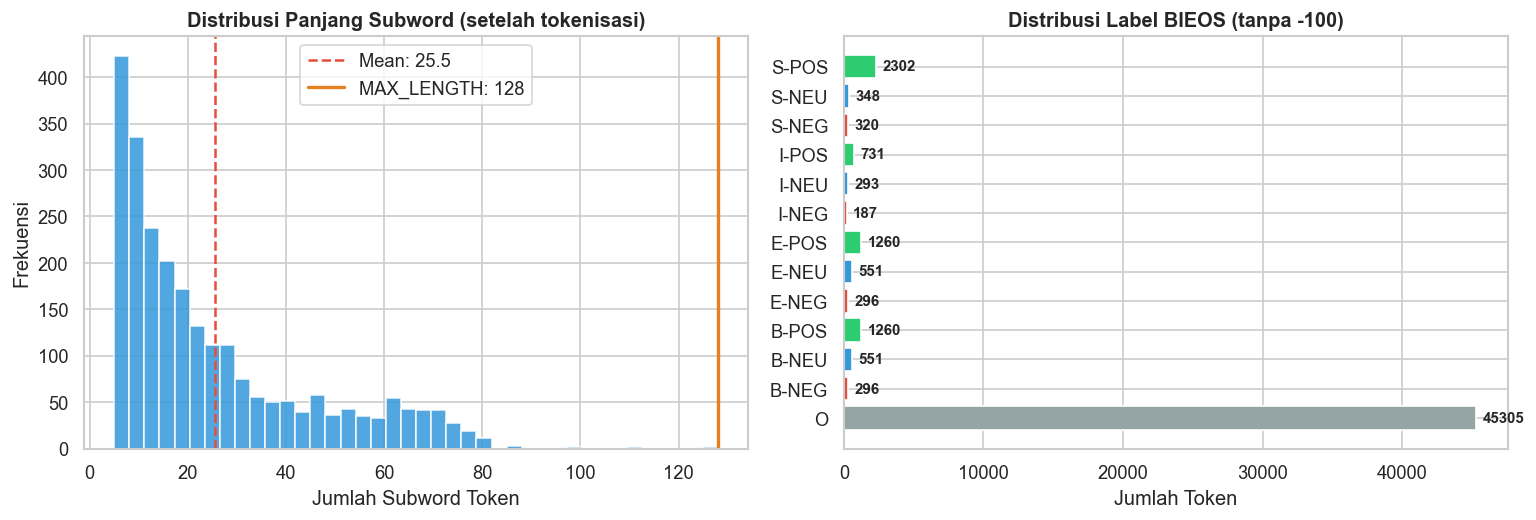

Statistik panjang subword:
  Min    : 5
  Max    : 128
  Mean   : 25.5
  Median : 18.0

Data terpotong (length == 128): 1 (0.0%)
  -> Pertimbangkan menaikkan MAX_LENGTH jika terlalu banyak yang terpotong


In [43]:
# Statistik subword lengths (non-padding)
actual_lengths = dataset['attention_mask'].sum(dim=1)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Histogram panjang subword
axes[0].hist(actual_lengths.numpy(), bins=40, color='#3498db', edgecolor='white', alpha=0.85)
axes[0].axvline(actual_lengths.float().mean().item(), color='#e74c3c', linestyle='--', linewidth=1.5,
                label=f"Mean: {actual_lengths.float().mean().item():.1f}")
axes[0].axvline(MAX_LENGTH, color='#e67e22', linestyle='-', linewidth=2,
                label=f"MAX_LENGTH: {MAX_LENGTH}")
axes[0].set_title('Distribusi Panjang Subword (setelah tokenisasi)', fontweight='bold')
axes[0].set_xlabel('Jumlah Subword Token')
axes[0].set_ylabel('Frekuensi')
axes[0].legend()

# Distribusi label (non-ignored)
flat_labels = dataset['labels'].flatten()
valid_labels = flat_labels[flat_labels != IGNORE_INDEX]
label_dist = Counter(valid_labels.tolist())

label_names = [id2label[lid] for lid, _ in sorted(label_dist.items())]
label_vals = [count for _, count in sorted(label_dist.items())]

colors = []
for name in label_names:
    if 'POS' in name: colors.append('#2ecc71')
    elif 'NEG' in name: colors.append('#e74c3c')
    elif 'NEU' in name: colors.append('#3498db')
    else: colors.append('#95a5a6')

axes[1].barh(label_names, label_vals, color=colors, edgecolor='white')
for i, (name, val) in enumerate(zip(label_names, label_vals)):
    axes[1].text(val + max(label_vals)*0.01, i, str(val), va='center', fontsize=9, fontweight='bold')
axes[1].set_title('Distribusi Label BIEOS (tanpa -100)', fontweight='bold')
axes[1].set_xlabel('Jumlah Token')

plt.tight_layout()
plt.show()

# Statistik ringkas
print(f"Statistik panjang subword:")
print(f"  Min    : {actual_lengths.min().item()}")
print(f"  Max    : {actual_lengths.max().item()}")
print(f"  Mean   : {actual_lengths.float().mean().item():.1f}")
print(f"  Median : {actual_lengths.float().median().item():.1f}")

truncated = (actual_lengths == MAX_LENGTH).sum().item()
print(f"\nData terpotong (length == {MAX_LENGTH}): {truncated} ({truncated/len(all_input_ids)*100:.1f}%)")
if truncated > 0:
    print(f"  -> Pertimbangkan menaikkan MAX_LENGTH jika terlalu banyak yang terpotong")

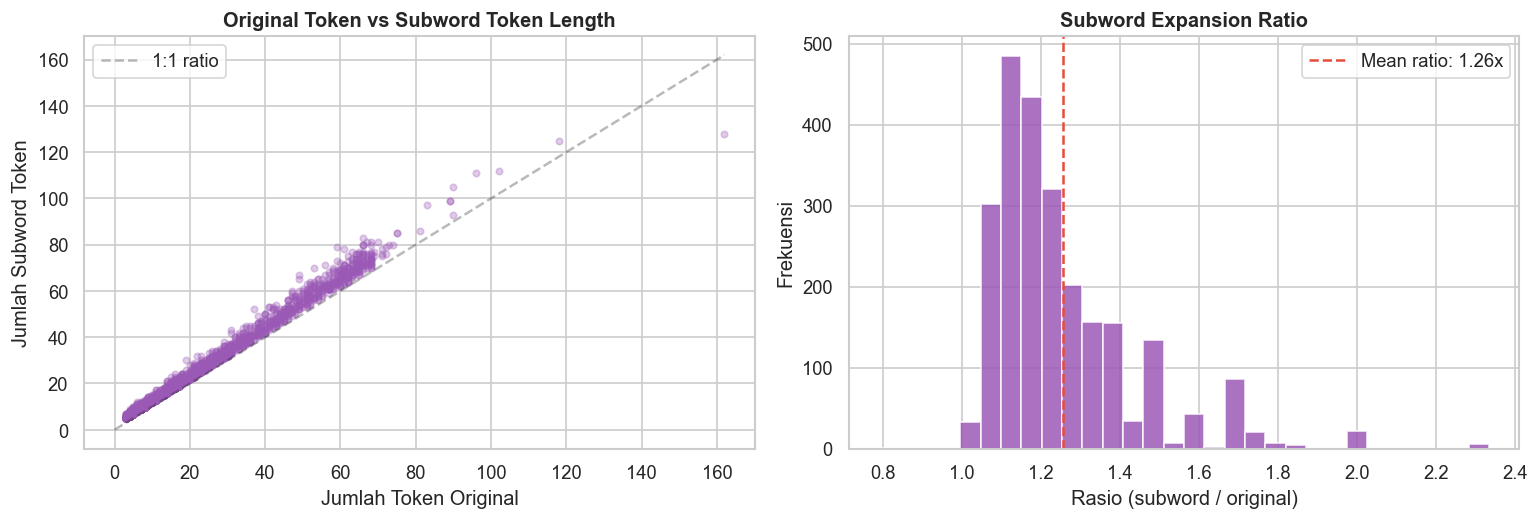

Rata-rata expansion: 1.26x (original → subword)


In [44]:
# Perbandingan: panjang original token vs subword token
original_lengths = [len(d['tokens']) for d in raw_data[:len(all_input_ids)]]
subword_lengths = actual_lengths.tolist()

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Scatter: original vs subword length
axes[0].scatter(original_lengths, subword_lengths, alpha=0.3, s=15, color='#9b59b6')
max_val = max(max(original_lengths), max(subword_lengths))
axes[0].plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='1:1 ratio')
axes[0].set_title('Original Token vs Subword Token Length', fontweight='bold')
axes[0].set_xlabel('Jumlah Token Original')
axes[0].set_ylabel('Jumlah Subword Token')
axes[0].legend()

# Histogram expansion ratio
ratios = [s / o if o > 0 else 0 for s, o in zip(subword_lengths, original_lengths)]
axes[1].hist(ratios, bins=30, color='#9b59b6', edgecolor='white', alpha=0.85)
axes[1].axvline(sum(ratios)/len(ratios), color='#e74c3c', linestyle='--', linewidth=1.5,
                label=f"Mean ratio: {sum(ratios)/len(ratios):.2f}x")
axes[1].set_title('Subword Expansion Ratio', fontweight='bold')
axes[1].set_xlabel('Rasio (subword / original)')
axes[1].set_ylabel('Frekuensi')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Rata-rata expansion: {sum(ratios)/len(ratios):.2f}x (original → subword)")

### 8. SIMPAN DATASET

In [45]:
torch.save(dataset, OUTPUT_PATH)

file_size = os.path.getsize(OUTPUT_PATH) / (1024 * 1024)
print(f"Dataset tersimpan di: {OUTPUT_PATH}")
print(f"Ukuran file: {file_size:.1f} MB")

# Verifikasi bisa di-load kembali
loaded = torch.load(OUTPUT_PATH, weights_only=False)
print(f"\nVerifikasi load:")
print(f"  input_ids shape    : {loaded['input_ids'].shape}")
print(f"  attention_mask shape: {loaded['attention_mask'].shape}")
print(f"  labels shape       : {loaded['labels'].shape}")
print(f"  label2id           : {loaded['label2id']}")
print(f"  model_name         : {loaded['model_name']}")

Dataset tersimpan di: d:\Kuliah\TA\Notebook\data\processed\dataset_indobert_bieos.pt
Ukuran file: 7.2 MB

Verifikasi load:
  input_ids shape    : torch.Size([2451, 128])
  attention_mask shape: torch.Size([2451, 128])
  labels shape       : torch.Size([2451, 128])
  label2id           : {'O': 0, 'B-NEG': 1, 'B-NEU': 2, 'B-POS': 3, 'E-NEG': 4, 'E-NEU': 5, 'E-POS': 6, 'I-NEG': 7, 'I-NEU': 8, 'I-POS': 9, 'S-NEG': 10, 'S-NEU': 11, 'S-POS': 12}
  model_name         : indobenchmark/indobert-large-p2
